    Problem Statement:

    The categorization of images into distinct classes is a pervasive task in computer vision, and it has a wide array of applications, including in pet identification and animal monitoring systems. In this assignment, we aim to develop a model capable of accurately distinguishing between cat and dog images. Instead of building a convolutional neural network (CNN) from scratch, we will leverage transfer learning using the VGG16 model, a pre-trained model on the ImageNet dataset. VGG16 is renowned for its effectiveness in image recognition tasks, but it does not have broad categories for cats and dogs. Therefore, we will utilize the convolutional (Conv) layers of VGG16 for feature extraction and add custom fully connected (Cat) layers for the classification task.

    Background
VGG16 is a pre-trained model. It is a convolutional neural network architecture that was originally proposed by the Visual Geometry Group (VGG) from the University of Oxford. It achieved high performance on the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) in 2014.

Pre-trained models like VGG16 are trained on large datasets (e.g., ImageNet) and can be used for various tasks such as image classification, object detection, or feature extraction in transfer learnin

Import Libraries

In [27]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

    Objectives:

Utilize VGG16 for Feature Extraction:

● Employ the VGG16 model, excluding its top layers, to serve as a feature extractor for cat and dog images.

● Ensure the input images are of the correct size (150x150) and preprocessed appropriately to match VGG16’s requirements.

In [28]:
#nitialized with weights pre-trained on the ImageNet dataset
#include_top=False: This argument indicates that the top layers of the VGG16 model, which are fully connected layers responsible for classification, should not be included. 
#By excluding these layers, we are essentially extracting the learned features from the convolutional base of the network.
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Data Preprocessing and Augmentation:

Implement image data generators for real-time data augmentation, ensuring a robust and varied dataset for training the classification layers.

In [29]:
#!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O /tmp/cats_and_dogs_filtered.zip
# !curl -o /tmp/cats_and_dogs_filtered.zip https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

#local_zip = '/tmp/cats_and_dogs_filtered.zip'
#zip_ref = zipfile.ZipFile(local_zip, 'r')
#zip_ref.extractall('/tmp')
#zip_ref.close()
#base_dir = '/tmp/cats_and_dogs_filtered'

base_dir = 'C:\\Users\\BHARAT\\Documents\\Data Science and AI - Intellipaat\\Assignment Submissions\\cats_vs_dogs'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
train_cats_dir = os.path.join(train_dir, 'cat')
train_dogs_dir = os.path.join(train_dir, 'dog')
validation_cats_dir = os.path.join(val_dir, 'cat')
validation_dogs_dir = os.path.join(val_dir, 'dog')

train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=40,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,width_shift_range=0.2,height_shift_range=0.3,fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(150, 150),batch_size=32,class_mode="categorical",shuffle=True)
val_generator = test_datagen.flow_from_directory(val_dir,target_size=(150, 150),batch_size=32,class_mode="categorical")



Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


Build and Train the Classification Model:

● Add custom fully connected layers on top of the VGG16 model for the classification task.

● Freeze the convolutional layers of VGG16 to retain the pre-trained features and only train the added classification layers.

In [30]:
# Add custom fully connected layers  on top of the VGG16 model for the classification task.
model = Sequential([
    base_model
    ,Flatten()
    ,Dense(256, activation='relu')
    ,Dropout(0.5)
    ,Dense(2, activation='softmax')
])

#Freeze the base model's layers to retain the pre-trained features
#Ensures the weights of the VGG16 layers are not updated during training. This retains the pre-trained features.
base_model.trainable = False

Model Compilation and Training:

● Compile the model using stochastic gradient descent, categorical cross-entropy as the loss function, and accuracy as the evaluation metric.


In [31]:
from tensorflow.keras.optimizers import SGD

# Compile the model with SGD optimizer
model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9),  # SGD with a learning rate and momentum
    loss='categorical_crossentropy',                 # Loss function for multi-class classification
    metrics=['accuracy']                             # Evaluation metric
)

# Model summary (optional)
model.summary()



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

● Train the model using the training data, and validate its performance using a validation set.

In [32]:
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1))

lr_callback = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Train the model
model.fit(train_generator,epochs=100,validation_data=val_generator,steps_per_epoch=100,validation_steps=50,callbacks=[lr_callback,early_stopping])



Epoch 1/100


c:\Users\BHARAT\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5659 - loss: 0.7615

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x0000013F62A607C0>
Traceback (most recent call last):

  File "c:\Users\BHARAT\anaconda3\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 270, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "c:\Users\BHARAT\anaconda3\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\BHARAT\anaconda3\Lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\BHARAT\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py", line 260, in _get_iterator
    for i, batch in enumerate(gen_fn()):

  File "c:\Users\BHARAT\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py", line 253, in generator_fn
    yield self.py_dataset[i]
          ~~~~~~~~~~~~~~~^^^

  File "c:\Users\BHARAT\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py", line 68, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\BHARAT\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py", line 313, in _get_batches_of_transformed_samples
    img = image_utils.load_img(
          ^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\BHARAT\anaconda3\Lib\site-packages\keras\src\utils\image_utils.py", line 236, in load_img
    img = pil_image.open(io.BytesIO(f.read()))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\BHARAT\anaconda3\Lib\site-packages\PIL\Image.py", line 3536, in open
    raise UnidentifiedImageError(msg)

PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x0000013F62A607C0>


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_29053]

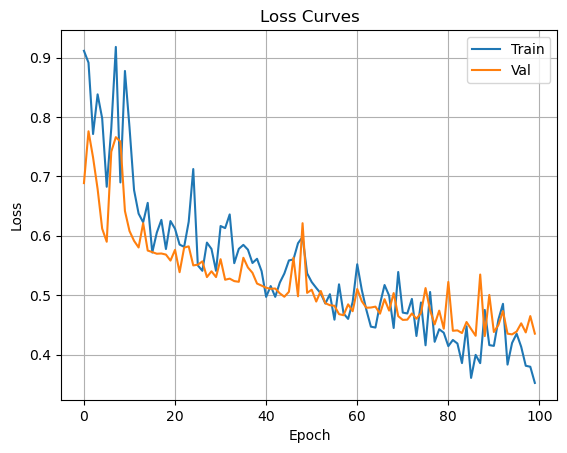

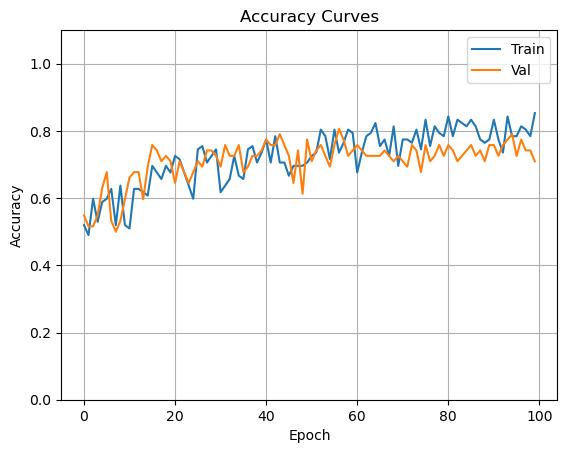

In [ ]:
#Track accuracy
train_loss = model.history.history["loss"]
val_loss = model.history.history["val_loss"]

train_acc = model.history.history["accuracy"]
val_acc = model.history.history["val_accuracy"]

plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend(["Train", "Val"])
plt.grid()
plt.show()

plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0,1.1)
plt.title("Accuracy Curves")
plt.legend(["Train", "Val"])
plt.grid()
plt.show()

Evaluate and Test the Model:

● Assess the model’s performance based on its accuracy in classifying images into cat or dog categories.

● Implement a prediction function to classify new images, providing the predicted category and the associated confidence level.